# Predicting oxidation states in crystal structure by maching learning

Introduction
Inorganic crystals play a vital role in all aspects of everyday life. The oxidation state of atoms in crystals are essential in determining their unique properties. It indicates the number of electrons from the atoms that are involved in chemical bonding. In crystal structures, atoms are arranged in complex repeating patterns where it can become very difficult for us to determine oxidation states by hand. People could use supercomputers to solve this problem. However, this is computationally expensive and not practical for lots of materials.   

With the advent of large computational materials science databases, there is a growing need for a novel approach to determine oxidation states in crystals rapidly and reliably. In this project, We used computational materials chemistry, machine learning, and data science to tackle this problem.

## Data retrieval and filtering

The data is taken from the 2017 edition of the Inorganic Crystal Structure Database (ICSD). In total there are distinct 40,972 structures and 428,796 oxidation states. The dataset is filtered to remove:
* Materials without oxidation states.
* Materials containing deuterium or other uncommon isotopes.
* Materials with fractional (or non-integer oxidation states).
* Materials that are not charge balanced (e.g., their oxidation states don’t add up to 0).
* Materials that contain non-metallic elements but whose oxidation states are all zero. These are materials which technically have oxidation states but they are all incorrectly set to zero.  

We can import the filtered dataset now.

In [ ]:
import pandas as pd

In [65]:
import matplotlib.pyplot as plt

In [66]:
df = pd.read_pickle("oxi_database.p")

We want to specify the element that the oxidation state belongs to. 

In [68]:
#add element labels to the dataset

df['site_symbol'] = [structure[site_idx].species_string 
                          for structure, site_idx in zip(df.structure, df.site_idx)]

## Oxidation States Analysis

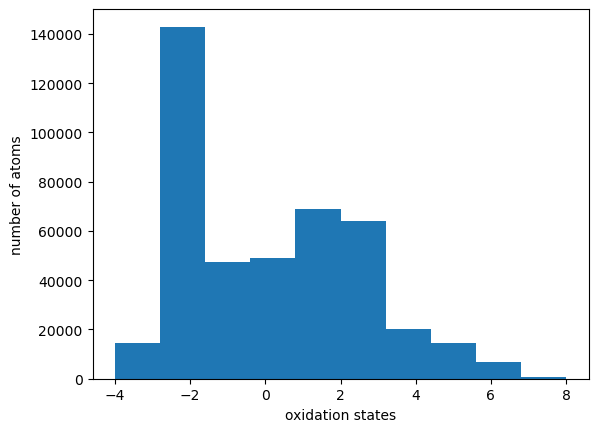

In [67]:
oxi_all = df['oxi_state'].values

plt.hist(oxi_all)

plt.xlabel('oxidation states')
plt.ylabel('number of atoms')

print()

In [ ]:
#plot the histogram of oxidation states of specific elements in one graph

oxygen_oxi = df[df['site_symbol'] == "O"].oxi_state.values
hydrogen_oxi = df[df['site_symbol'] == "H"].oxi_state.values

plt.hist([oxygen_oxi], stacked=True, label=["O"],
        bins=[-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5])
plt.legend()
plt.xlabel('oxidation states')
plt.ylabel('number of atoms')
plt.gca().set_xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
print()

In [ ]:
#plot the histogram of elements

plt.figure(figsize=(25,10))
plt.hist(df.site_symbol, bins=len(df['site_symbol'].unique()), align="left")
plt.xlabel('Elements')
plt.ylabel('Number of elements')

In [70]:
from collections import Counter
element_min=list(Counter(df['site_symbol'].values).keys()) #the list of all the elements that exist in the dataframe
element_all=df['site_symbol'].values 
oxi_all = df['oxi_state'].values

In [ ]:
#plot histogram of oxidation states of every element at once

import numpy as np

oxi_atom=[]

for i in range(len(element_min)):
    for x in range(len(element_all)):
        if element_all[x] == element_min[i]:
            oxi_atom.append(oxi_all[x])
            
    counts, edges, _ = plt.hist(oxi_atom, bins=[-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]
            ,align = 'mid')
    
    plt.xlabel(f'oxidation states of {element_min[i]}')
    plt.gca().set_xticks([-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
    
    for i in range(len(counts)):
        bin_count = counts[i]
        bin_edge_left = edges[i]
        bin_edge_right = edges[i + 1]
        bin_center = (bin_edge_left + bin_edge_right) / 2
        plt.text(bin_center, bin_count, str(int(bin_count)), ha='center', va='bottom')
    
    plt.show()
    
    oxi_atom=[]

## Generating descriptors for machine learning

We used Matminer that contains featurizers for transforming materials primitives into machine-learnable features. We generate three kinds of features that are related to atoms' oxidation states.  

1. Elemental properties  
We generate them for both the site that we are predicting and the whole structure it belongs to. 

2. Geometrical properties   
It is about coordination and local geometry of the site.

3. Voronoi coordination  
It is the number of first nearest neighbors of a site in Voronoi diagram.

In [ ]:
from matminer.featurizers.conversions import StructureToComposition

stc = StructureToComposition()
df = stc.featurize_dataframe(df, "structure")

In [ ]:
from matminer.featurizers.composition import ElementProperty

epf = ElementProperty.from_preset("magpie")
epf.set_n_jobs(8)
df = epf.featurize_dataframe(df, "composition")

In [ ]:
from matminer.featurizers.conversions import StrToComposition

df = StrToComposition(target_col_id = "site_composition").featurize_dataframe(df, "site_symbol")

In [ ]:
from matminer.featurizers.composition import ElementProperty

epf_site = ElementProperty.from_preset("magpie")
epf_site.set_n_jobs(8)

for column in df.columns:
    if column.startswith('Magpie'):
        new_column_name = 'comp_' + column
        df.rename(columns={column: new_column_name}, inplace=True)

df = epf_site.featurize_dataframe(df, "site_composition")

In [ ]:
from matminer.featurizers.site.misc import CoordinationNumber

cn = CoordinationNumber()

df = cn.featurize_dataframe(df, ["structure", "site_idx"], ignore_errors=True)

In [ ]:
from matminer.featurizers.site import CrystalNNFingerprint

cnnf = CrystalNNFingerprint.from_preset("ops")

df = cnnf.featurize_dataframe(df, ["structure", "site_idx"], ignore_errors=True)

In [ ]:
df.to_pickle("featurized_df3.p")

## Random Forest Regression

We tried the random forest model as a starting point.

In [ ]:
#import the featurized dataset

df_featurized = pd.read_pickle("featurized_df3.p")

In [ ]:
y = df_featurized['oxi_state'].values

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=1)

In [ ]:
X = df_featurized.drop(['structure', "composition", 'oxi_state', 'site_symbol','site_composition','structure_idx', 'site_idx'], axis = 1)

In [ ]:
rf.fit(X, y)

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=9, random_state=1, shuffle=True)

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=kfold)

rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Mean RMSE: {:.3f}'.format(np.mean(rmse_scores)))

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred_reg = cross_val_predict(rf, X, y, cv=kfold)

### Model Evaluation

In [ ]:
df_featurized["oxi_state predicted regression"] = y_pred_reg
df_featurized["absolute_error regression"] = df_featurized["oxi_state"] - df_featurized["oxi_state predicted regression"]

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

reference_line = go.Scatter(
    x=[-8, 8],
    y=[-8, 8],
    line=dict(color="black", dash="dash"),
    mode="lines",
    showlegend=False
)

fig = px.scatter(
    df_featurized, 
    x="oxi_state", 
    y="oxi_state predicted regression",  
    color="absolute_error regression", 
    color_continuous_scale=px.colors.sequential.Bluered,
)

fig.add_trace(reference_line)
fig.show()

In [ ]:
absolute_error_reg = df_featurized["absolute_error regression"].values

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6)) 

counts, edges, _ = plt.hist(absolute_error_reg, bins=[-2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25], align = 'mid')

for i in range(len(counts)):
        bin_count = counts[i]
        bin_edge_left = edges[i]
        bin_edge_right = edges[i + 1]
        bin_center = (bin_edge_left + bin_edge_right) / 2
        plt.text(bin_center, bin_count, str(int(bin_count)), ha='center', va='bottom')

plt.gca().set_xticks([-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6])
    
plt.show()

### Applying RFECV to reduce the number of features

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, mean_squared_error

min_features_to_select = 1  # Minimum number of features to consider
scoring = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

rfecv = RFECV(
    estimator=rf,
    step=5,
    cv=kfold,
    scoring=scoring,
    min_features_to_select=min_features_to_select,
    n_jobs=8,
)

rfecv.fit(X, y)

print(f"Optimal features: {X.columns[rfecv.support_]}")

print("Optimal number of features:", rfecv.n_features_)

X_optimized = X.loc[:, rfecv.support_]

In [ ]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of tests")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## Random Forest Classification

As we want to predict integer oxidation states for now. Random Forest Classification could be a better choice.

In [1]:
df_featurized = pd.read_pickle("featurized_df3.p")

In [2]:
df_featurized = df_featurized.dropna()

In [5]:
X = df_featurized.drop(['structure', "composition", 'oxi_state', 'site_symbol','site_composition','structure_idx', 'site_idx'], axis = 1)

In [7]:
y = df_featurized['oxi_state'].values

For each elemental property, it has the maximum, minimum, range, mean, mode, average deviation associated with it.
But for the site specific elemental properties, the minimum value, maximum value, mean and mode are the same. The average deviation is 0. So we eliminated all of them except the mean value.

In [6]:
#drop the repetitive site-specific elemental features

drop_columns = []
for c in X.columns:
    if (
        "MagpieData minimum" in c or
        "MagpieData maximum" in c or 
        "MagpieData range" in c or 
        "MagpieData mode" in c or 
        "MagpieData avg_dev" in c
    ) and "comp_" not in c:
        drop_columns.append(c)

len(drop_columns)

X = X.drop(drop_columns, axis=1)

### Load the Model

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=1, min_samples_split=5, max_depth=None, min_samples_leaf=2)

### Evaluation Methods

In [9]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=6, random_state=1, shuffle=True)

For scoring matrice we use both accuracy and precision. We use weighted average precision as it takes into account the imbalance of the classes.

In [10]:
from sklearn.metrics import make_scorer, precision_score

macro_precision_scorer = make_scorer(precision_score, average='weighted', zero_division=0)

### L1 Regularization

We have over 200 features features now so we want to to reduce the number of features.

In [13]:
#split the dataset into training set and test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model with L1 penalty
logistic_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)

# Fit the model to the training data
logistic_l1.fit(X_train, y_train)

# Get the coefficients
coefficients = logistic_l1.coef_[0]

# Identify non-zero coefficients (selected features)
selected_features = [i for i, coef in enumerate(coefficients) if coef != 0]

In [14]:
# Extract the selected features from the original data
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
X_selected = X.iloc[:, selected_features]

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': [15, None],
    'min_samples_split': [6, 5],
    'min_saples_leaf': [2, 4],
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Create the Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=kfold, scoring=macro_precision_scorer)

# Fit the Grid Search to the data
grid_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [ ]:
#Get the score on training set
cv_score = grid_search.best_score_
cv_score

In [ ]:
# Get the score on test set
test_score = grid_search.score(X_test_selected, y_test)
test_score

In [ ]:
final_model = RandomForestClassifier(**grid_search.best_params_)

In [15]:
# Fit the final model with all the whole dataset

clf.fit(X_selected, y)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=1)

### RFECV

We could look at the optimimal features since the performance is relatively the same during RFE.

In [26]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(
    estimator=clf,
    step=5,
    cv=kfold,
    scoring=macro_precision_scorer,
    min_features_to_select=4,
    n_jobs=8,
)

rfecv.fit(X_selected, y)

print(f"Optimal features: {X_selected.columns[rfecv.support_]}")

print("Optimal number of features:", rfecv.n_features_)

X_clf_optimized = rfecv.transform(X_selected)

Optimal features: Index(['comp_MagpieData maximum Number', 'comp_MagpieData range Number',
       'comp_MagpieData mean Number', 'comp_MagpieData avg_dev Number',
       'comp_MagpieData mode Number',
       'comp_MagpieData minimum MendeleevNumber',
       'comp_MagpieData maximum MendeleevNumber',
       'comp_MagpieData range MendeleevNumber',
       'comp_MagpieData mean MendeleevNumber',
       'comp_MagpieData avg_dev MendeleevNumber',
       'comp_MagpieData mode MendeleevNumber',
       'comp_MagpieData minimum AtomicWeight',
       'comp_MagpieData maximum AtomicWeight',
       'comp_MagpieData range AtomicWeight',
       'comp_MagpieData mean AtomicWeight',
       'comp_MagpieData avg_dev AtomicWeight',
       'comp_MagpieData mode AtomicWeight', 'comp_MagpieData minimum MeltingT',
       'comp_MagpieData maximum MeltingT', 'comp_MagpieData range MeltingT',
       'comp_MagpieData mean MeltingT', 'comp_MagpieData avg_dev MeltingT',
       'comp_MagpieData mode MeltingT', 'com

In [27]:
rfecv.score(X_selected, y)

0.9957073935480258

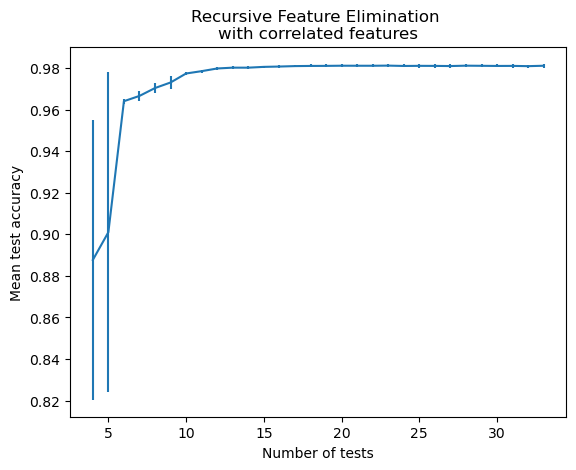

In [28]:
import matplotlib.pyplot as plt
min_features_to_select=4

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of tests")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
ranking = rfecv.ranking_

# Map ranking to feature names
ranked_features = [feature for rank, feature in sorted(zip(ranking, X.columns.values))]

# Print the features eliminated at each step
for i in range(2, ranking):
    eliminated_features = [feature for rank, feature in zip(ranking, X.columns.values) if rank == i]
    print(f"Eliminated at step {i}: {eliminated_features}")

### Model Evaluation

In [42]:
from sklearn.model_selection import cross_val_score

scores_clf = cross_val_score(clf, X_selected, y, scoring='accuracy', cv=kfold)

In [43]:
import numpy as np
print(np.mean(scores_clf))

0.981037876616449


In [17]:
from sklearn.model_selection import cross_val_predict

y_pred_clf = cross_val_predict(clf, X_selected, y, cv=kfold)

In [18]:
df_featurized["oxi_state predicted classification"] = y_pred_clf
df_featurized["absolute_error classification"] = df_featurized["oxi_state"] - df_featurized["oxi_state predicted classification"]

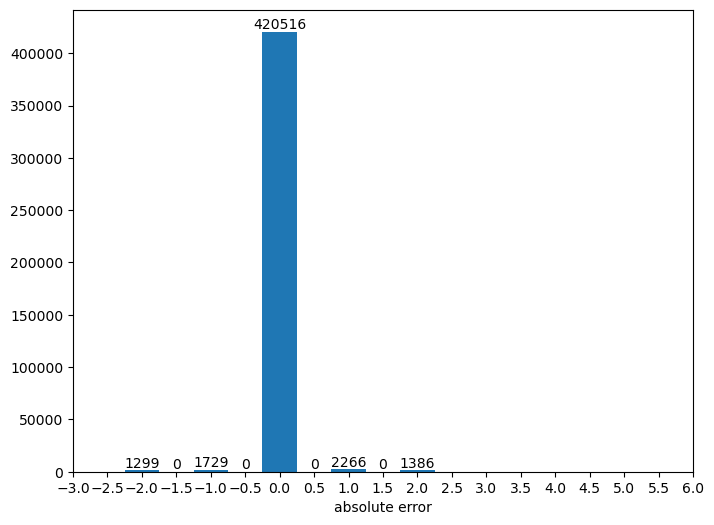

In [25]:
absolute_error_clf = df_featurized["absolute_error classification"].values

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6)) 

counts, edges, _ = plt.hist(absolute_error_clf, bins=[-2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25]
            ,align = 'mid')

for i in range(len(counts)):
        bin_count = counts[i]
        bin_edge_left = edges[i]
        bin_edge_right = edges[i + 1]
        bin_center = (bin_edge_left + bin_edge_right) / 2
        plt.text(bin_center, bin_count, str(int(bin_count)), ha='center', va='bottom')

plt.gca().set_xticks([-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6])

plt.xlabel('absolute error classification')

plt.show()

### Ploting Training Curve of the Model

In [75]:
from sklearn.model_selection import learning_curve
import numpy as np

In [77]:
# Define the training sizes and number of folds for cross-validation
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curves
train_sizes_abs, train_scores, validation_scores = learning_curve(
    clf, X_selected, y, train_sizes=train_sizes, cv=kfold, scoring=macro_precision_scorer
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

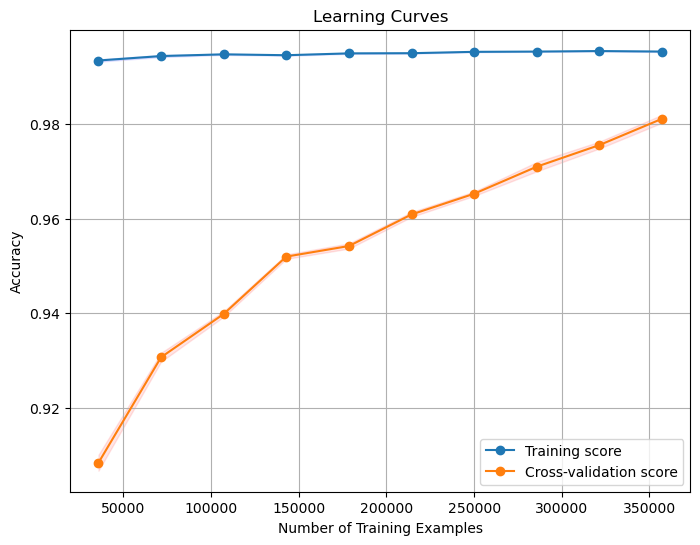

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_abs, train_scores_mean, label='Training score', marker='o')
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.plot(train_sizes_abs, validation_scores_mean, label='Cross-validation score', marker='o')
plt.fill_between(train_sizes_abs, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="r")

plt.title('Learning Curves')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

### Model interpretation

#### Feature Importance

In [ ]:
#Look at the most important features

ntop = 20
top_feat = np.argsort(clf.feature_importances_)[-ntop:]
plt.bar(range(ntop), clf.feature_importances_[top_feat])
plt.xticks(range(ntop), labels=X.columns[top_feat], rotation=90)

print()

#### SHAP analysis

In [26]:
import shap

explainer = shap.TreeExplainer(clf)

In [27]:
n_rows_to_sample = min(1000, X_test_selected.shape[0])

smaller_df = X_test_selected.sample(n=n_rows_to_sample)

In [ ]:
shap_values = explainer.shap_values(smaller_df)

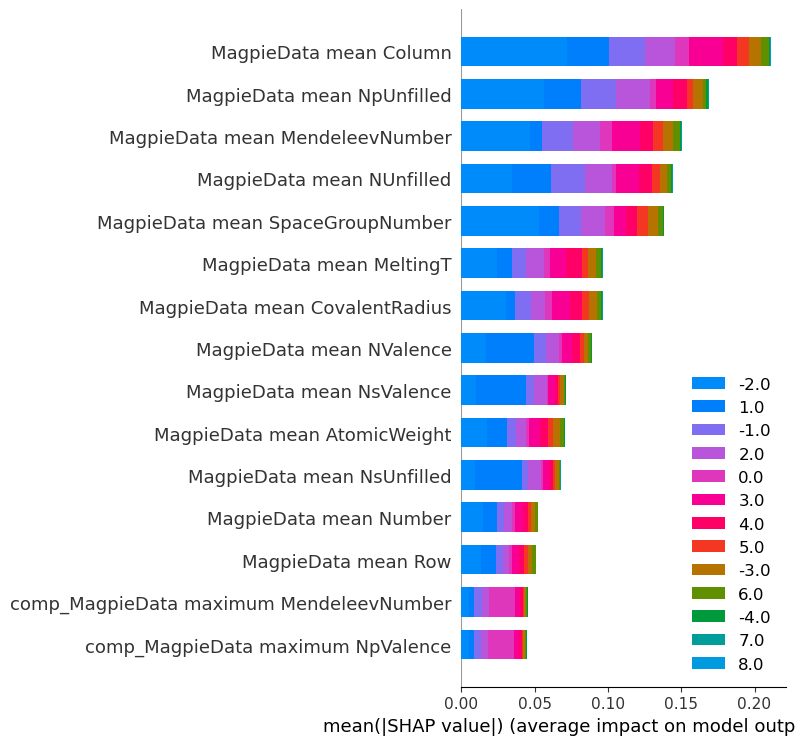

In [107]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 8})

shap.summary_plot(shap_values, smaller_df.values,
                  max_display=15, class_names=clf.classes_, feature_names=smaller_df.columns)

plt.show()

### Evaluation on specific compositions where metals have multiple oxidation states

In [1]:
pip install mpcontribs-client

  Obtaining dependency information for mpcontribs-client from https://files.pythonhosted.org/packages/51/dd/ecf22156bb4ff59d830ce4a63650205f8b4ef659b8fdea273f18cf763c16/mpcontribs_client-5.5.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 558.9 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 488.0 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for requests-futures from https://files.pythonhosted.org/packages/af/ca/ca664ed374fab67535482532c3c05bb5dbe5850e7dff2491eb827c318e48/requests_futures-1.0.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for ujson from https://files.pythonhosted.org/packages/e2/a5/3e4a004c2626340b6149d74dd529027d7166cfd86cadd27decf8480ac149/ujson-5.8.0-cp39-cp39-macosx_11_0_arm64.whl.m

In [ ]:
from mp_api.client import MPRester

mpr = MPRester(api_key='sljrZpvg76aMwy5yA8NIW6Cq8Uv5LTRF')

s = mpr.get_structure_by_material_id("mp-20078") #Pb2O3
a = mpr.get_structure_by_material_id("mp-149") #Si
b = mpr.get_structure_by_material_id("mp-546794") #SiO4
c = mpr.get_structure_by_material_id("mp-22633") #Pb3O4
d = mpr.get_structure_by_material_id("mp-499") #Ag2O2
e = mpr.get_structure_by_material_id("mp-230") #Sb2O4

In [ ]:
#check if the test compositions are in the training set

result = df_1.isin(e)
value_exists = result.values.any()
print(value_exists)

In [ ]:
s.add_oxidation_state_by_guess()
print(s.species)

In [ ]:
c.add_oxidation_state_by_guess()
print(c.species)

In [47]:
df_test = pd.DataFrame(
    {"structure": [s] * len(s) + [a] * len(a) + [b] * len(b) + [c] * len(c) + [d] * len(d) + [e] * len(e),
     "site_idx": list(range(len(s))) + list(range(len(a))) + list(range(len(b))) + list(range(len(c))) + list(range(len(d)))+ list(range(len(e)))
    }
)

In [48]:
df_test['site_symbol'] = [structure[site_idx].species_string 
                          for structure, site_idx in zip(df_test.structure, df_test.site_idx)]

In [49]:
from matminer.featurizers.conversions import StructureToComposition

stc = StructureToComposition()
df_test = stc.featurize_dataframe(df_test, "structure")

StructureToComposition:   0%|          | 0/84 [00:00<?, ?it/s]

In [50]:
from matminer.featurizers.composition import ElementProperty

epf = ElementProperty.from_preset("magpie")
epf.set_n_jobs(8)
df_test = epf.featurize_dataframe(df_test, "composition")

ElementProperty:   0%|          | 0/84 [00:00<?, ?it/s]

In [51]:
from matminer.featurizers.conversions import StrToComposition

df_test = StrToComposition(target_col_id = "site_composition").featurize_dataframe(df_test, "site_symbol")

StrToComposition:   0%|          | 0/84 [00:00<?, ?it/s]

In [52]:
from matminer.featurizers.composition import ElementProperty

epf_site = ElementProperty.from_preset("magpie")
epf_site.set_n_jobs(8)

for column in df_test.columns:
    if column.startswith('Magpie'):
        new_column_name = 'comp_' + column
        df_test.rename(columns={column: new_column_name}, inplace=True)

df_test = epf_site.featurize_dataframe(df_test, "site_composition")

ElementProperty:   0%|          | 0/84 [00:00<?, ?it/s]

In [53]:
from matminer.featurizers.site.misc import CoordinationNumber

cn = CoordinationNumber()

df_test = cn.featurize_dataframe(df_test, ["structure", "site_idx"], ignore_errors=True)

CoordinationNumber:   0%|          | 0/84 [00:00<?, ?it/s]

In [54]:
from matminer.featurizers.site import CrystalNNFingerprint

cnnf = CrystalNNFingerprint.from_preset("ops")

df_test = cnnf.featurize_dataframe(df_test, ["structure", "site_idx"], ignore_errors=True)

CrystalNNFingerprint:   0%|          | 0/84 [00:00<?, ?it/s]

/Users/mac/miniconda3/envs/matminer/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4140: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/Users/mac/miniconda3/envs/matminer/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3934: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/Users/mac/miniconda3/envs/matminer/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:4140: UserWarning: No oxidation states specified on sites! For better results, set the site oxidation states in the structure.
  warnings.warn(
/Users/mac/miniconda3/envs/matminer/lib/python3.9/site-packages/pymatgen/analysis/local_env.py:3934: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
/Users/mac

In [55]:
X1 = df_test.drop(['structure', "composition", 'site_symbol','site_composition', 'site_idx'], axis = 1)

In [56]:
X1 = X1.drop(drop_columns, axis = 1)

In [57]:
X1 = X1.iloc[:, selected_features]

In [58]:
y1 = clf.predict(X1)

In [60]:
df_predict = df_test
df_predict["predicted values"] = list(y1)

In [ ]:
print(df_predict)

,structure,site_idx,site_symbol,composition,comp_MagpieData minimum Number,comp_MagpieData maximum Number,comp_MagpieData range Number,comp_MagpieData mean Number,comp_MagpieData avg_dev Number,comp_MagpieData mode Number,...,wt CN_16,wt CN_17,wt CN_18,wt CN_19,wt CN_20,wt CN_21,wt CN_22,wt CN_23,wt CN_24,predicted values
0,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",0,Pb,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,4.0
1,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",1,Pb,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,4.0
2,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",2,Pb,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,4.0
3,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",3,Pb,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,4.0
4,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",4,Pb,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,2.0
5,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",5,Pb,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,2.0
6,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",6,Pb,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,2.0
7,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",7,Pb,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,2.0
8,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",8,O,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,-2.0
9,"[[4.28548049 3.37652799 6.38253383] Pb, [1.444...",9,O,"(Pb, O)",8.0,82.0,74.0,37.600000,35.520000,8.0,...,0,0,0,0,0,0,0,0,0,-2.0


## XGBoost

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_test_encoded = le.fit_transform(y_test)

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="multi:softprob", num_class=len(set(y_encoded)))

In [ ]:
cv_scores = cross_val_score(xgb_model, X_selected, y_encoded, cv=5, scoring=macro_precision_scorer)